In [1]:
import json
import os.path as osp

import torch
from torch.optim import Adam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import *

import pydgn
from pydgn.data.dataset import TUDatasetInterface, DatasetInterface
from pydgn.experiment.util import s2c  # string to class

import sys

import seaborn as sns
sns.set_palette("colorblind")

plt.rcParams.update({"text.usetex": True})
plt.rcParams['font.size'] = 12

axes_font_size = 18

import dgn


In [2]:
def load_model(results_folder, model, dataset, dim_node_features, dim_edge_features, num_classes, udn : bool):
    if udn:
        prefix = 'udn_'
    else:
        prefix = ''
    
    best_config_dgn = json.load(open(results_folder + f"{prefix}{model}_{dataset}/MODEL_ASSESSMENT/OUTER_FOLD_1/MODEL_SELECTION/winner_config.json","r"))['config']['supervised_config']
    final_model_ckpt_dgn = torch.load(results_folder + f"{prefix}{model}_{dataset}/MODEL_ASSESSMENT/OUTER_FOLD_1/final_run1/best_checkpoint.pth", map_location=torch.device('cpu'))


    model_dgn = s2c(best_config_dgn['model'])(dim_node_features, dim_edge_features, num_classes, None, best_config_dgn)
    model_dgn.eval()
    model_dgn.to('cpu')
    model_dgn.load_state_dict(final_model_ckpt_dgn['model_state'])

    return model_dgn

## Prepare Data Loaders

In [3]:
from pydgn.data.provider import DataProvider
from torch_geometric.loader import DataLoader

def load_loaders(dataset_root, dataset_class, dataset, batch_size=256):

    shuffle = False
    
    
    splits_filepath = f'DATA_SPLITS/{dataset}/{dataset}_outer1_inner1.splits'
    
    dataset_getter = DataProvider(dataset_root, splits_filepath, 
                                  s2c(dataset_class), dataset,
                                  s2c(data_loader_class), {},
                                  outer_folds=1, inner_folds=1)
    dataset_getter.set_exp_seed(42)
    dataset_getter.set_inner_k(0)
    dataset_getter.set_outer_k(0)
    
    # Instantiate the Data Loaders
    data_loader_args = dict(batch_size=batch_size, shuffle=shuffle)
    
    train_loader = dataset_getter.get_outer_train(**data_loader_args)
    val_loader = dataset_getter.get_outer_val(**data_loader_args)
    test_loader = dataset_getter.get_outer_test(**data_loader_args)

    return train_loader, val_loader, test_loader


## Obtain message filters for model on all nodes and layers

In [4]:
def compute_filters_per_layer(model, device, train_loader, val_loader, test_loader):
    message_filters_all_layers = []

    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for loader in [train_loader, val_loader, test_loader]:
            for data in loader:
                data.to(device)
        
                edge_index = data.edge_index
                batch = data.batch
                
                preds, embeddings, extra = model(data)

                if extra[-1] is not None:
                    message_filters_all_layers.append(extra[-1].detach().cpu())
                else:
                    return None
        
        message_filters = torch.cat(message_filters_all_layers, dim=0)
        
        return 100*(message_filters.sum((0, 2)) / (message_filters.shape[0]*message_filters.shape[2]))

### Percentage of Total Information that is propagated at each layer of AMP

In [5]:
dataset_root = 'DATA'
dataset_class = {'Eccentricity': 'dataset.GraphPropertyPrediction',
                     'Diameter': 'dataset.GraphPropertyPrediction',
                     'SSSP': 'dataset.GraphPropertyPrediction',
                     'peptides-func': 'dataset.Peptides',
                     'peptides-struct': 'dataset.Peptides'}

data_loader_class = 'torch_geometric.loader.DataLoader'
device = 'cuda:0'

dim_node_features = {'Eccentricity': 2,
                     'Diameter': 2,
                     'SSSP': 2,
                     'peptides-func': 9,
                     'peptides-struct': 9}
dim_edge_features = 0
num_classes = {'Eccentricity': 1,
                     'Diameter': 1,
                     'SSSP': 1,
                     'peptides-func': 10,
                     'peptides-struct': 11}

Processing gcn on Eccentricity
Processed gcn on Eccentricity
Processing gcn on Diameter
Processed gcn on Diameter
Processing gcn on SSSP
Processed gcn on SSSP
Processing gcn on peptides-func
Processed gcn on peptides-func
Processing gcn on peptides-struct
Processed gcn on peptides-struct


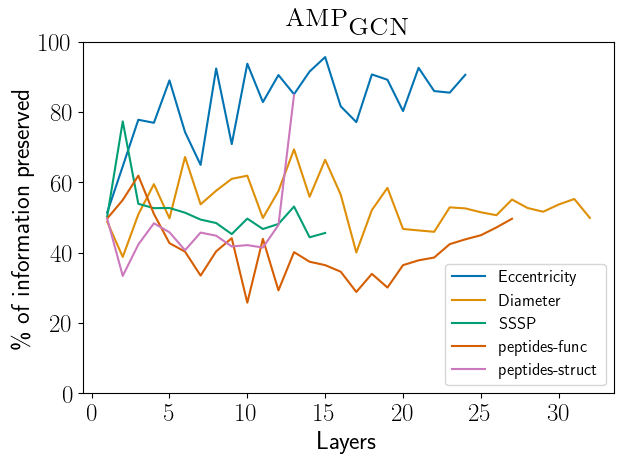

In [37]:
plt.figure()

for dataset in ['Eccentricity', 'Diameter', 'SSSP' , 'peptides-func', 'peptides-struct']:

    models = ['gcn'] if dataset in ['Eccentricity', 'Diameter', 'SSSP'] else ['gcn']

    results_folder = '/mnt/local/ferrica/UDN_RESULTS_300PATIENCE/' if dataset in ['Eccentricity', 'Diameter', 'SSSP'] else '/mnt/local/ferrica/LRGB_RESULTS/'
    
    for model in models:
        print(f'Processing {model} on {dataset}')
        
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        
        train_loader, val_loader, test_loader = load_loaders(dataset_root, dataset_class[dataset], dataset)
        
        message_filters = compute_filters_per_layer(udn_model, device, train_loader, val_loader, test_loader)
        
        if message_filters is not None:
            plt.plot(torch.arange(message_filters.shape[0]) + 1, message_filters,
                    label=rf'{dataset}')
        else:
            print(f'Message filters is none for {dataset}')

        print(f'Processed {model} on {dataset}')
title = str(r'\textsc{AMP}$_{\textsc{%s}}$' % model.upper())
plt.title(title, fontsize=axes_font_size, y=1.02)

# Set font properties for the axes labels
font_properties = {'size': axes_font_size}
plt.xlabel('Layers', fontdict=font_properties)
plt.ylabel('\% of information preserved', fontdict=font_properties)

# Set font properties for the tick labels
plt.xticks(fontsize=axes_font_size)
plt.yticks(fontsize=axes_font_size)

plt.ylim((0.,100.))

plt.legend()
plt.tight_layout()
plt.savefig(f'images/AMP_{model}_information_preserved.pdf')

## Layer Analysis

Processing gcn on Eccentricity
Processed gcn on Eccentricity
Processing gin on Eccentricity
Processed gin on Eccentricity
Processing adgn on Eccentricity
Processed adgn on Eccentricity
Processing gcn on Diameter
Processed gcn on Diameter
Processing gin on Diameter
Processed gin on Diameter
Processing adgn on Diameter
Processed adgn on Diameter
Processing gcn on SSSP
Processed gcn on SSSP
Processing gin on SSSP
Processed gin on SSSP
Processing adgn on SSSP
Processed adgn on SSSP
Processing gcn on peptides-func
Processed gcn on peptides-func
Processing gine on peptides-func
Processed gine on peptides-func
Processing gatedgcn on peptides-func
Processed gatedgcn on peptides-func
Processing gcn on peptides-struct
Processed gcn on peptides-struct
Processing gine on peptides-struct
Processed gine on peptides-struct
Processing gatedgcn on peptides-struct
Processed gatedgcn on peptides-struct


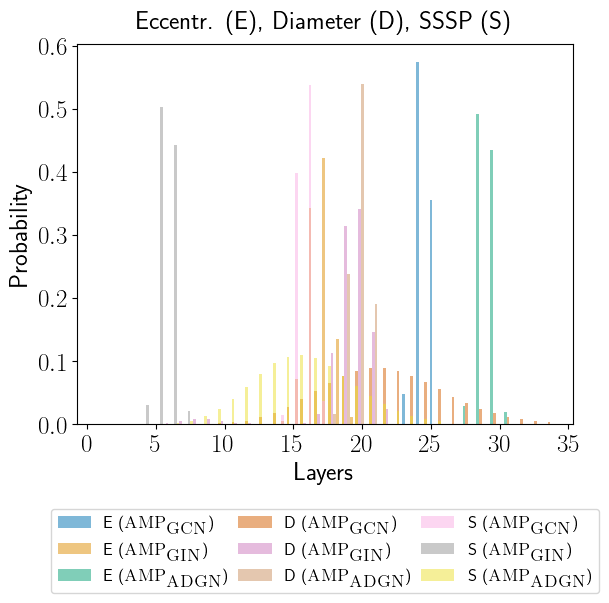

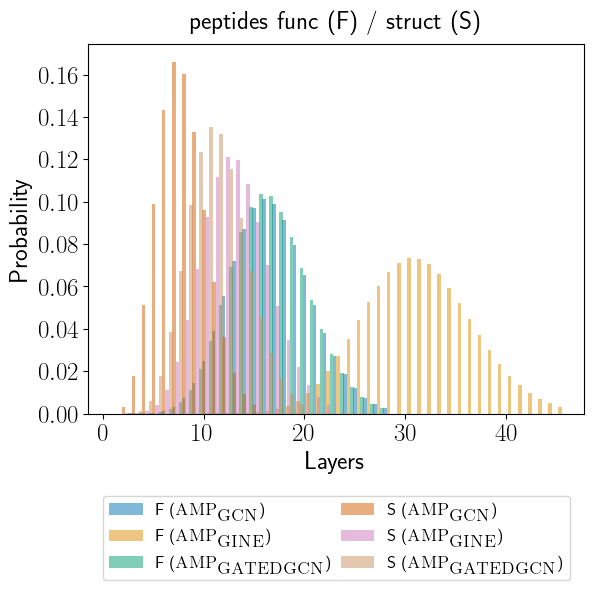

In [72]:
plt.figure(figsize=(6.4, 4.94))

# Set the width of the bars
bar_width = 0.2

c = 0
for dataset in ['Eccentricity', 'Diameter', 'SSSP']:

    models = ['gcn', 'gin', 'adgn'] 

    for model in models:

        results_folder = '/mnt/local/ferrica/UDN_RESULTS_300PATIENCE/' if model != 'gin' else '/mnt/local/ferrica/UDN_RESULTS/'
        
        print(f'Processing {model} on {dataset}')
        
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        
        qL_probs = udn_model.variational_L.compute_probability_vector().detach().numpy()

        if dataset == 'Eccentricity':
            dataset_str = 'E'
        elif dataset == 'Diameter':
            dataset_str = 'D'
        elif dataset == 'SSSP':
            dataset_str = 'S'
        plt.bar(torch.arange(qL_probs.shape[0]) + 1 + bar_width*c, qL_probs, 
                width=bar_width, 
                label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset_str, model.upper()), 
                alpha=0.5)

        c += 1

        print(f'Processed {model} on {dataset}')

plt.title('Eccentr. (E), Diameter (D), SSSP (S)', fontsize=axes_font_size, y=1.02)

# Set font properties for the axes labels
font_properties = {'size': axes_font_size}
plt.xlabel('Layers', fontdict=font_properties)
plt.ylabel('Probability', fontdict=font_properties)

# Set font properties for the tick labels
plt.xticks(fontsize=axes_font_size)
plt.yticks(fontsize=axes_font_size)

legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, columnspacing=0.5)
# plt.tight_layout()
plt.savefig(f'images/AMP_distributions_synthetic.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

plt.figure(figsize=(6.4, 4.8))

c = 0

# Set the width of the bars
bar_width = 0.35

for dataset in ['peptides-func', 'peptides-struct']:

    models = ['gcn', 'gine', 'gatedgcn']

    results_folder = '/mnt/local/ferrica/LRGB_RESULTS/'
    
    for model in models:
        print(f'Processing {model} on {dataset}')
        
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        
        qL_probs = udn_model.variational_L.compute_probability_vector().detach().numpy()


        dataset_str = 'F' if (dataset == 'peptides-func') else 'S'
        plt.bar(torch.arange(qL_probs.shape[0]) + 1 + bar_width*c, qL_probs, 
                width=bar_width, 
                label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset_str, model.upper()), 
                alpha=0.5)

        c += 1
        
        print(f'Processed {model} on {dataset}')
plt.title('peptides func (F) / struct (S)', fontsize=axes_font_size, y=1.02)

# Set font properties for the axes labels
font_properties = {'size': axes_font_size}
plt.xlabel('Layers', fontdict=font_properties)
plt.ylabel('Probability', fontdict=font_properties)

# Set font properties for the tick labels
plt.xticks(fontsize=axes_font_size)
plt.yticks(fontsize=axes_font_size)

legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, columnspacing=0.5)
# plt.tight_layout()
plt.savefig(f'images/AMP_distributions_peptides.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

## Oversmoothing Analysis

In [6]:
def compute_oversmoothing(model, train_loader, val_loader, test_loader):
    total_layerwise_energies = 0.
    num_total_nodes = 0.
    
    with torch.no_grad():
        for loader in [train_loader, val_loader, test_loader]:
            for data in loader:
                data.to(device)
        
                edge_index = data.edge_index
                batch = data.batch
                _, embeddings, _ = model(data)
                
                sq_node_diff = torch.sum((embeddings[edge_index[0]] - embeddings[edge_index[1]])**2, dim=-1)
                total_layerwise_energies += sq_node_diff.sum(0)
                num_total_nodes += sq_node_diff.shape[0] 
                
    layerwise_energies = torch.sqrt(total_layerwise_energies / num_total_nodes)
    return layerwise_energies

In [35]:
plt.figure()

for dataset in ['Eccentricity', 'Diameter', 'SSSP']:

    models = ['gcn']#, 'gin', 'adgn'] 

    for model in models:

        results_folder = '/mnt/local/ferrica/UDN_RESULTS_300PATIENCE/' if model != 'gin' else '/mnt/local/ferrica/UDN_RESULTS/'
        
        print(f'Processing {model} on {dataset}')

        base_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=False)
        base_model.to(device)
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        udn_model.to(device)
        
        train_loader, val_loader, test_loader = load_loaders(dataset_root, dataset_class[dataset], dataset)

        layerwise_energies = compute_oversmoothing(udn_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        base_layerwise_energies = compute_oversmoothing(base_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        
        plt.plot(torch.arange(base_layerwise_energies.shape[0]) + 1, np.log(base_layerwise_energies), label=r'%s (\textsc{%s})' % (dataset, model.upper()), linestyle='--')
        plt.plot(torch.arange(layerwise_energies.shape[0]) + 1, np.log(layerwise_energies), label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset, model.upper()))

        print(f'Processed {model} on {dataset}')


for dataset in ['peptides-func', 'peptides-struct']:

    models = ['gcn']#, 'gin', 'adgn'] 

    for model in models:

        results_folder = '/mnt/local/ferrica/LRGB_RESULTS/'
        
        print(f'Processing {model} on {dataset}')

        base_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=False)
        base_model.to(device)
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        udn_model.to(device)
        
        train_loader, val_loader, test_loader = load_loaders(dataset_root, dataset_class[dataset], dataset)

        layerwise_energies = compute_oversmoothing(udn_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        base_layerwise_energies = compute_oversmoothing(base_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        
        plt.plot(torch.arange(base_layerwise_energies.shape[0]) + 1, np.log(base_layerwise_energies), label=r'%s (\textsc{%s})' % (dataset, model.upper()), linestyle='--')
        plt.plot(torch.arange(layerwise_energies.shape[0]) + 1, np.log(layerwise_energies), label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset, model.upper()))

        print(f'Processed {model} on {dataset}')

# Set font properties for the axes labels
font_properties = {'size': axes_font_size}
plt.xlabel('Layers', fontdict=font_properties)
plt.ylabel(r'$\ln$ Dirichlet Energy', fontdict=font_properties)

# Set font properties for the tick labels
plt.xticks(fontsize=axes_font_size)
plt.yticks(fontsize=axes_font_size)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.savefig(f'images/Dirichlet_Energy.pdf')

Processing gcn on Eccentricity


NameError: name 'compute_oversmoothing' is not defined

<Figure size 640x480 with 0 Axes>

## Oversquashing Analysis (slow, only on validation loader!)

In [7]:
def compute_oversquashing(model, loader, total_nodes_to_process=10):

    sensitivity_matrix = None
    print(f'Need to process {len(loader)} batches...')
    c = 0
    for data in loader:
        data.to(device)
        data.x.requires_grad=True
        batch = data.batch
        max_batch = batch.max()
        num_nodes, _ = data.x.shape

        preds, embeddings, extra = model(data, retain_grad=True)

        if sensitivity_matrix is None:
            sensitivity_matrix = torch.zeros(len(embeddings))
        
        for nodeid in range(num_nodes):
            print(nodeid)
            # print(preds.shape)
            for f in range(embeddings[-1].shape[1]):
                embeddings[-1][nodeid, f].backward(retain_graph=True)
        
                # layer_wise_sensitivity = []
                for hidden_layer in range(len(embeddings)):
                    if embeddings[hidden_layer].grad != None:
                        sensitivity_matrix[hidden_layer] += torch.norm(embeddings[hidden_layer].grad, p=1).cpu()
                        embeddings[hidden_layer].grad = None

            c += 1
            if c == total_nodes_to_process:
                break

        if c == total_nodes_to_process:
            print(f'Processed {c} nodes')
            print('Stopping here for computational reasons!')
            break

        break
    return sensitivity_matrix

Processing gcn on Eccentricity
Need to process 20 batches...
0


/tmp/ipykernel_434530/2628889754.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if embeddings[hidden_layer].grad != None:


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Processed 250 nodes
Stopping here for computational reasons!
Need to process 20 batches...
0
1
2
3
4
5
6
7
8
9
1

/tmp/ipykernel_434530/2628889754.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if embeddings[hidden_layer].grad != None:


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Processed 250 nodes
Stopping here for computational reasons!
Need to process 20 batches...
0
1
2
3
4
5
6
7
8
9
1

/tmp/ipykernel_434530/2628889754.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if embeddings[hidden_layer].grad != None:


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Processed 250 nodes
Stopping here for computational reasons!
Need to process 20 batches...
0
1
2
3
4
5
6
7
8
9
10


/tmp/ipykernel_434530/2628889754.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if embeddings[hidden_layer].grad != None:


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Processed 250 nodes
Stopping here for computational reasons!
Need to process 146 batches...
0
1
2
3
4
5
6
7
8
9


/tmp/ipykernel_434530/2628889754.py:26: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  if embeddings[hidden_layer].grad != None:


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
Processed 250 nodes
Stopping here for computational reasons!
Need to process 146 batches...
0
1
2
3
4
5
6
7
8
9


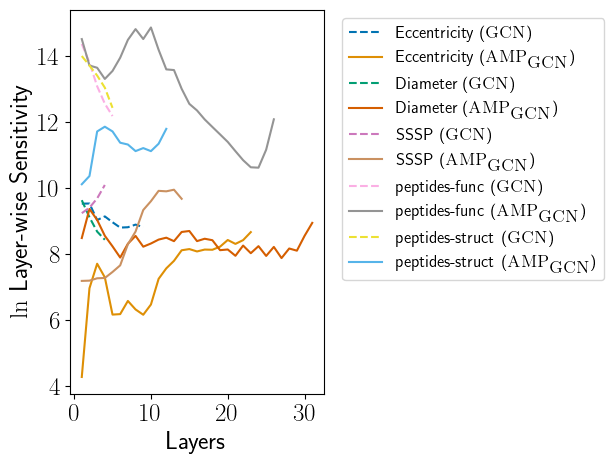

In [75]:
device = 'cuda:0'


models = ['gcn'] 

for model in models:
    plt.figure()
    for dataset in ['Eccentricity', 'Diameter', 'SSSP', 'peptides-func', 'peptides-struct']:

        if dataset in ['Eccentricity', 'Diameter', 'SSSP']:
            results_folder = '/mnt/local/ferrica/UDN_RESULTS_300PATIENCE/'
        else:
            results_folder = '/mnt/local/ferrica/LRGB_RESULTS/'

        # for some reason one specific GIN checkpoint is not loading
        if model == 'gin':
            if dataset == 'Eccentricity':
                results_folder = '/mnt/local/ferrica/UDN_RESULTS/'
        
        print(f'Processing {model} on {dataset}')
    
        base_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=False)
        base_model.to(device)
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        udn_model.to(device)
        
        train_loader, val_loader, test_loader = load_loaders(dataset_root, dataset_class[dataset], dataset, batch_size=32)
    
        layerwise_sensitivity = compute_oversquashing(udn_model, val_loader, total_nodes_to_process=250).cpu().detach().numpy()
        base_layerwise_sensitivity = compute_oversquashing(base_model, val_loader, total_nodes_to_process=250).cpu().detach().numpy()

        layerwise_sensitivity[-1] = 1.
        base_layerwise_sensitivity[-1] = 1.

        torch.save(layerwise_sensitivity, f'images/AMP_{model}_{dataset}_sensitivity.pt')
        torch.save(base_layerwise_sensitivity, f'images/base_{model}_{dataset}_sensitivity.pt')
        
        plt.plot(torch.arange(base_layerwise_sensitivity.shape[0]-1) + 1, np.log(base_layerwise_sensitivity[:-1]), label=r'%s (\textsc{%s})' % (dataset, model.upper()), linestyle='--')
        plt.plot(torch.arange(layerwise_sensitivity.shape[0]-1) + 1, np.log(layerwise_sensitivity[:-1]), label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset, model.upper()))
        
        print(f'Processed {model} on {dataset}')
        
    # Set font properties for the axes labels
    font_properties = {'size': axes_font_size}
    plt.xlabel('Layers', fontdict=font_properties)
    plt.ylabel(r'$\ln$ Layer-wise Sensitivity', fontdict=font_properties)
    
    # Set font properties for the tick labels
    plt.xticks(fontsize=axes_font_size)
    plt.yticks(fontsize=axes_font_size)
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")    
    plt.tight_layout()
    plt.savefig(f'images/AMP_{model}_sensitivity.pdf')

Processing gcn on Eccentricity
Processed gcn on Eccentricity
Processing gcn on Diameter
Processed gcn on Diameter
Processing gcn on SSSP
Processed gcn on SSSP
Processing gcn on peptides-func
Processed gcn on peptides-func
Processing gcn on peptides-struct
Processed gcn on peptides-struct
Processing gcn on Eccentricity
Processed gcn on Eccentricity
Processing gcn on Diameter
Processed gcn on Diameter
Processing gcn on SSSP
Processed gcn on SSSP
Processing gcn on peptides-func
Processed gcn on peptides-func
Processing gcn on peptides-struct
Processed gcn on peptides-struct


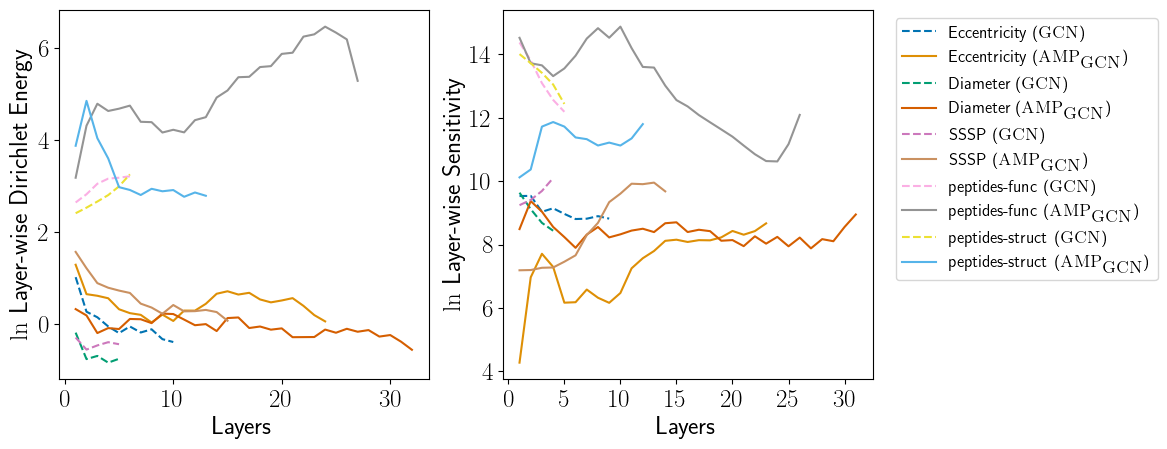

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5,4.8))

for dataset in ['Eccentricity', 'Diameter', 'SSSP']:

    models = ['gcn']#, 'gin', 'adgn'] 

    for model in models:

        results_folder = '/mnt/local/ferrica/UDN_RESULTS_300PATIENCE/' if model != 'gin' else '/mnt/local/ferrica/UDN_RESULTS/'
        
        print(f'Processing {model} on {dataset}')

        base_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=False)
        base_model.to(device)
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        udn_model.to(device)
        
        train_loader, val_loader, test_loader = load_loaders(dataset_root, dataset_class[dataset], dataset)

        layerwise_energies = compute_oversmoothing(udn_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        base_layerwise_energies = compute_oversmoothing(base_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        
        axes[0].plot(torch.arange(base_layerwise_energies.shape[0]) + 1, np.log(base_layerwise_energies), label=r'%s (\textsc{%s})' % (dataset, model.upper()), linestyle='--')
        axes[0].plot(torch.arange(layerwise_energies.shape[0]) + 1, np.log(layerwise_energies), label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset, model.upper()))

        print(f'Processed {model} on {dataset}')


for dataset in ['peptides-func', 'peptides-struct']:

    models = ['gcn']#, 'gin', 'adgn'] 

    for model in models:

        results_folder = '/mnt/local/ferrica/LRGB_RESULTS/'
        
        print(f'Processing {model} on {dataset}')

        base_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=False)
        base_model.to(device)
        udn_model = load_model(results_folder, model, dataset, dim_node_features[dataset], dim_edge_features, num_classes[dataset], udn=True)
        udn_model.to(device)
        
        train_loader, val_loader, test_loader = load_loaders(dataset_root, dataset_class[dataset], dataset)

        layerwise_energies = compute_oversmoothing(udn_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        base_layerwise_energies = compute_oversmoothing(base_model, train_loader, val_loader, test_loader).cpu().detach().numpy()
        
        axes[0].plot(torch.arange(base_layerwise_energies.shape[0]) + 1, np.log(base_layerwise_energies), label=r'%s (\textsc{%s})' % (dataset, model.upper()), linestyle='--')
        axes[0].plot(torch.arange(layerwise_energies.shape[0]) + 1, np.log(layerwise_energies), label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset, model.upper()))

        # Set font properties for the tick labels
        plt.xticks(fontsize=axes_font_size)
        plt.yticks(fontsize=axes_font_size)

        axes[0].tick_params(axis='both', which='major', labelsize=axes_font_size)

        # Set font properties for the axes labels
        font_properties = {'size': axes_font_size}
        axes[0].set_xlabel('Layers', fontdict=font_properties)
        axes[0].set_ylabel(r'$\ln$ Layer-wise Dirichlet Energy', fontdict=font_properties)

        print(f'Processed {model} on {dataset}')

models = ['gcn'] 

for model in models:
    for dataset in ['Eccentricity', 'Diameter', 'SSSP', 'peptides-func', 'peptides-struct']:

        if dataset in ['Eccentricity', 'Diameter', 'SSSP']:
            results_folder = '/mnt/local/ferrica/UDN_RESULTS_300PATIENCE/'
        else:
            results_folder = '/mnt/local/ferrica/LRGB_RESULTS/'

        # for some reason one specific GIN checkpoint is not loading
        if model == 'gin':
            if dataset == 'Eccentricity':
                results_folder = '/mnt/local/ferrica/UDN_RESULTS/'
        
        print(f'Processing {model} on {dataset}')

        with torch.no_grad():
            layerwise_sensitivity = torch.load(f'images/AMP_{model}_{dataset}_sensitivity.pt')
            base_layerwise_sensitivity = torch.load(f'images/base_{model}_{dataset}_sensitivity.pt')

        
        axes[1].plot(torch.arange(base_layerwise_sensitivity.shape[0]-1) + 1, np.log(base_layerwise_sensitivity[:-1]), label=r'%s (\textsc{%s})' % (dataset, model.upper()), linestyle='--')
        axes[1].plot(torch.arange(layerwise_sensitivity.shape[0]-1) + 1, np.log(layerwise_sensitivity[:-1]), label=r'%s (\textsc{AMP}$_{\textsc{%s}}$)' % (dataset, model.upper()))
        
        print(f'Processed {model} on {dataset}')
        
    # Set font properties for the axes labels
    font_properties = {'size': axes_font_size}
    plt.xlabel('Layers', fontdict=font_properties)
    plt.ylabel(r'$\ln$ Layer-wise Sensitivity', fontdict=font_properties)
    
    # Set font properties for the tick labels
    plt.xticks(fontsize=axes_font_size)
    plt.yticks(fontsize=axes_font_size)  

legend = plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
# plt.tight_layout()
plt.savefig(f'images/oversmoothing_oversquashing.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')